In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pylab
import glob, os
import scipy.stats as stats
from scipy.stats import gaussian_kde
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import timeit
%matplotlib inline

In [2]:
# Format to remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# options of samples

In [3]:
Sample = pd.read_csv('R:/Angela/fast_trips/2015SampleDataSpring_6day.csv')

C:\Anaconda\lib\site-packages\pandas\io\parsers.py:1159: DtypeWarning: Columns (72,75,77,83,117) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
Sample.shape

(494613, 120)

#my_data

In [5]:
my_data = Sample

In [6]:
#Or try a small sample if needed
'''
msk = np.random.rand(len(Sample)) < 0.95
my_data = Sample[~msk]
'''

'\nmsk = np.random.rand(len(Sample)) < 0.95\nmy_data = Sample[~msk]\n'

In [7]:
def data_content(data):
    data = data[['ON', 'OFF', 'VEHNO', 'ANAME', 'STOPA', 'YR', 'HR', 'MIN', 'SEC', 'DHR', 'DMIN', 'DSEC', 'ROUTE', 'LOAD', 'date_id']]
    return data

In [8]:
test = data_content(my_data)
test.shape

(494613, 15)

In [9]:
test.columns

Index([u'ON', u'OFF', u'VEHNO', u'ANAME', u'STOPA', u'YR', u'HR', u'MIN', u'SEC', u'DHR', u'DMIN', u'DSEC', u'ROUTE', u'LOAD', u'date_id'], dtype='object')

#Prepare bus info

In [10]:
vehicles = pd.read_csv(r'R:\Angela\fast_trips\Vehicles.csv')
fleet = pd.read_csv(r'R:\Angela\fast_trips\Copy of Fleet.csv')

# Artic
vehicles.Artic = vehicles.Length.map({"60'" : 1, "40'" : 0, "30'" : 0})
vehicles.loc[:,'Artic'] = pd.Series(vehicles.Artic, index=vehicles.index)
df_artic = vehicles.set_index('Equip_Type').to_dict()['Artic']
fleet['Artic'] = fleet['Equip_Type'].map(df_artic)
df_vehnum_artic = fleet.set_index('VehNum').to_dict()['Artic']

# Low Floor
vehicles.Floor = vehicles['Low Floor'].map({'Y': 1, 'N' : 0})
vehicles.loc[:,'Floor'] = pd.Series(vehicles.Floor, index=vehicles.index)
df_floor = vehicles.set_index('Equip_Type').to_dict()['Floor']
fleet['Floor'] = fleet['Equip_Type'].map(df_floor)
df_vehnum_floor = fleet.set_index('VehNum').to_dict()['Floor']

# Door
df_doors = vehicles.set_index('Equip_Type').to_dict()['Doors']
fleet['Doors'] = fleet['Equip_Type'].map(df_doors)
df_vehnum_doors = fleet.set_index('VehNum').to_dict()['Doors']

# Capacity
vehicles.loc[:,'Total Capacity'] = pd.Series(vehicles['Total Capacity'], index=vehicles.index)
df_capacity = vehicles.set_index('Equip_Type').to_dict()['Total Capacity']
fleet['capacity'] = fleet['Equip_Type'].map(df_capacity)
df_vehnum_capacity = fleet.set_index('VehNum').to_dict()['capacity']

# Prepare route type

In [11]:
route_type = pd.read_csv(r'R:\Angela\fast_trips\MuniRouteTypes.csv')
route_type = route_type.dropna()
dict_route_type = {}
dict_route_type = route_type.set_index('APC Route ID')['Type'].to_dict()

#Step1: Prepare basic variables

In [12]:
def get_x_y(data):
    start = timeit.default_timer()
    # Before cleaning records, get the load data from the previous stop
    data['pre_load'] = data['LOAD'].shift()

    # Get rid of rows where certain fields has null/nan values
    data = data.dropna(subset = ['ON', 'OFF', 'VEHNO'])
    data = data[data['ON'] + data['OFF'] != 0]

    # COMPUTE TIMESTOP=((HR * 3600) + (MIN * 60) + SEC)
    start = timeit.default_timer()
    data['COMPUTE_TIMESTOP'] = data['HR']*3600 + data['MIN']*60 + data['SEC']
    # COMPUTE DOORCLOSE=(( DHR * 3600) + (DMIN * 60) + DSEC)
    data['COMPUTE_DOORCOLSE'] = data['DHR']*3600 + data['DMIN']*60 + data['DSEC']
    # COMPUTE DOORDWELL=DOORCLOSE - TIMESTOP
    data['COMPUTE_DOORDWELL'] = data['COMPUTE_DOORCOLSE'] - data['COMPUTE_TIMESTOP']
    # Appling door dwell time less than 120 secs
    data = data.loc[data['COMPUTE_DOORDWELL'] <= 120]
    data = data[data['COMPUTE_DOORDWELL'] != 0]
    stop = timeit.default_timer()
    print 'compute dwell time:', stop - start

    # Keep rows that satisfy a query:
    start = timeit.default_timer()
    data['Doors'] = data['VEHNO'].map(df_vehnum_doors) 
    data['Artic'] = data['VEHNO'].map(df_vehnum_artic)
    data['Floor'] = data['VEHNO'].map(df_vehnum_floor)
    data['capacity'] = data['VEHNO'].map(df_vehnum_capacity)
    data['two_doors'] = data['Doors'].map({2: 1, 3: 0})
    data['three_doors'] = data['Doors'].map({2: 0, 3: 1})
    #data['all_door_boarding']= data.apply(lambda x: x['mo'] > 6, axis=1).map({False: 0, True: 1})
    
    # Create dummie variables for route id
    data['Route Type'] = data['ROUTE'].map(dict_route_type)
    just_dummies_route = pd.get_dummies(data['Route Type'])
    step_1 = pd.concat([data, just_dummies_route], axis=1)
    step_1.drop(['Local'], inplace=True, axis=1)
    data = step_1
    stop = timeit.default_timer()
    print 'add veh&route info:', stop - start

    # Create interaction variables
    start = timeit.default_timer()
    data['on_threedoors'] = data['ON']*data['three_doors']
    data['off_threedoors'] = data['OFF']*data['three_doors']
    data['on_floor'] = data['ON']*data['Floor']
    data['off_floor'] = data['OFF']*data['Floor']
    data['floor_threedoors'] = data['Floor']*data['three_doors']
    data['floor_twodoors'] = data['Floor']*data['two_doors']
    #data['on_all_door_boarding'] = data['ON']*data['all_door_boarding']
    #data['off_all_door_boarding'] = data['OFF']*data['all_door_boarding']
    data['on_express'] = data['ON']*data['Express']
    data['off_express'] = data['OFF']*data['Express']
    data['on_rapid'] = data['ON']*data['Rapid']
    data['off_rapid'] = data['OFF']*data['Rapid']
    data['on_owl'] = data['ON']*data['OWL']
    data['off_owl'] = data['OFF']*data['OWL']
    stop = timeit.default_timer()
    print 'add interaction variables:', stop - start

    return data

## Step2: Adding more passenger activity variables

In [13]:
def passenger_var(data):
    start = timeit.default_timer()
    data['max_pasg'] = data[['ON', 'OFF']].max(axis=1)
    print 'data shape:', data.shape
    data['abs_pasg'] = (data['ON'] - data['OFF']).abs()
    print 'data shape:', data.shape
    
    # A passenger friction factor was constructed to account for passenger activity on buses with standees. 
    # It was posited that heavily loaded buses have greater dwell times. 
    # STANDEES are the number of passengers when LOAD minus 60% of bus capacity is positive. 
    data['pre_standees']= data['pre_load'] - 0.60 * data['capacity']
    data['pre_crowding']= data.apply(lambda x: x['pre_standees'] > 0, axis=1).map({False: 0, True: 1})
    # A proxy variable was constructed by adding ONS, OFFS, and STANDEES.
    data['friction'] = ((data['ON'] + data['OFF'] + (data['pre_standees']).abs()) * data['pre_crowding']).abs()
    print 'data shape:', data.shape
    stop = timeit.default_timer()
    print 'add passenger activity variables:', stop - start

    # Remove the corner data, which is the first and last stop data
    start = timeit.default_timer()
    # COMPUTE EOL = RINDEX(ANAME,' - EOL') 
    data['eol'] = data.apply(lambda x: '- EOL' in x['ANAME'], axis=1).map({False: 1, True: 0})
    # Remove the last stop
    data = data.loc[data['eol'] == 1]
    # Remove the first stop
    data = data.loc[data['STOPA'] != 1]
    stop = timeit.default_timer()
    print 'remove corner data:', stop - start
    
    return data

In [14]:
step1 = get_x_y(test)

compute dwell time: 0.165244963895
add veh&route info: 0.403263713564
add interaction variables: 0.0380787768578


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
step2 = passenger_var(step1)

data shape: (272383, 42)
data shape: (272383, 43)
data shape: (272383, 46)
add passenger activity variables: 4.33908440882
remove corner data: 4.09174167123


# Step3: Prepare vehicle ID variables

In [16]:
# Create dummie variables for bus id 
def create_vehID_day(data):
    start = timeit.default_timer()
    data['vehno_date'] = data.VEHNO.astype(str) + '_' + data.date_id.astype(str)
    #person_table['person_id'] = person_table.hh_id.astype(str) + '_' + person_table.pno.astype(str) 
    just_dummies_veh = pd.get_dummies(data['vehno_date'])
    data = pd.concat([data, just_dummies_veh], axis=1)
    #get rid of one dummy variable to avoid the dummy variable trap
    #step_1.drop([8515], inplace=True, axis=1)
    stop = timeit.default_timer()
    print 'data shape:', data.shape
    print 'add vehid&day variables:', stop - start
    
    return data

In [17]:
step3 = create_vehID_day(step2)

data shape: (270819, 991)
add vehid&day variables: 15.1493861337


In [18]:
step3.columns

Index([u'ON', u'OFF', u'VEHNO', u'ANAME', u'STOPA', u'YR', u'HR', u'MIN', u'SEC', u'DHR', u'DMIN', u'DSEC', u'ROUTE', u'LOAD', u'date_id', u'pre_load', u'COMPUTE_TIMESTOP', u'COMPUTE_DOORCOLSE', u'COMPUTE_DOORDWELL', u'Doors', u'Artic', u'Floor', u'capacity', u'two_doors', u'three_doors', u'Route Type', u'Express', u'OWL', u'Rapid', u'on_threedoors', u'off_threedoors', u'on_floor', u'off_floor', u'floor_threedoors', u'floor_twodoors', u'on_express', u'off_express', u'on_rapid', u'off_rapid', u'on_owl', u'off_owl', u'max_pasg', u'abs_pasg', u'pre_standees', u'pre_crowding', u'friction', u'eol', u'vehno_date', u'5446_1', u'5446_2', u'5446_4', u'5446_5', u'5446_6', u'5447_1', u'5447_2', u'5447_4', u'5447_5', u'5447_6', u'5448_1', u'5448_2', u'5448_3', u'5448_4', u'5448_5', u'5449_1', u'5449_2', u'5449_3', u'5449_4', u'5449_5', u'5449_6', u'5450_1', u'5450_2', u'5450_3', u'5450_5', u'5450_6', u'5451_2', u'5451_3', u'5451_5', u'5451_6', u'5452_1', u'5452_2', u'5452_3', u'5452_4', u'5452_5',

# Step4: Delete a vehicle variable in each route type

In [19]:
# Get three dataframes for three bus type
test = step3
df_art = test.loc[test.Artic == 1]
df_std_low = test.loc[(test.Artic == 0) & (test.Floor == 1)]
df_std_high = test.loc[(test.Artic == 0) & (test.Floor == 0)]

In [20]:
# Get the bus IDs, who runs one route type in a day. 
def delet_dict_1(df):
    del_dict = {}
    df = df.dropna()
    print len(df)
    for veh_day in np.unique(df.vehno_date):
        df_veh = df.loc[df.vehno_date == veh_day]
        if (len(np.unique(df_veh['Route Type'])) == 1):
            rte_type = np.unique(df_veh['Route Type'])
            rte_type = str(rte_type)
            del_dict[rte_type] = veh_day
    print del_dict
    return del_dict

In [21]:
# Get the bus IDs, who runs three route types in a day. 
def delet_dict_3(df):
    del_dict = {}
    df = df.dropna()
    print len(df)
    for veh_day in np.unique(df.vehno_date):
        df_veh = df.loc[df.vehno_date == veh_day]
        if (len(np.unique(df_veh['Route Type'])) == 3):
            rte_type = np.unique(df_veh['Route Type'])
            rte_type = str(rte_type)
            del_dict[rte_type] = veh_day
    print del_dict
    return del_dict

In [22]:
print np.unique(df_art['Route Type'])
print np.unique(df_std_low['Route Type'])
print np.unique(df_std_high['Route Type'])

['Express' 'Local' 'Rapid']
['Express' 'Local' 'OWL' 'Rapid']
[nan 'Express' 'Local' 'Rapid']


C:\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [23]:
print 'Articulated bus:'
del_art_1 = delet_dict_1(df_art)
print 'Standard bus with low floor:'
del_std_low_1 = delet_dict_1(df_std_low)
del_std_low_3 = delet_dict_3(df_std_low)
print 'Standard bus with high floor:'
del_std_high_1 = delet_dict_1(df_std_high)
del_std_high_3 = delet_dict_3(df_std_high)

Articulated bus:
66458
{"['Express']": '6403_1', "['Local']": '7123_1', "['Rapid']": '6403_6'}
Standard bus with low floor:
85341
{"['Rapid']": '8711_1', "['Local']": '8750_1', "['Express']": '8743_6'}
85341
{"['Local' 'OWL' 'Rapid']": '8721_4', "['Express' 'Local' 'OWL']": '8735_5', "['Express' 'Local' 'Rapid']": '8733_4'}
Standard bus with high floor:
117808
{"['Express']": '8231_3', "['Local']": '8228_1'}
117808
{"['Express' 'Local' 'Rapid']": '8221_1'}


In [24]:
# Create a dictionary that including the bus_day_id that need to be dropped
del_bus = {}
# Articulated bus
del_bus['Express1'] = '6403_1'
del_bus['Local1'] = '7123_1'
del_bus['Rapid1'] = '6403_6'
#Standard bus with low floor
del_bus['Express2'] = '8743_6'
del_bus['Local2'] = '8721_4' #Including Rapid2, OWL2
#Standard bus with high floor
del_bus['Express3'] = '8221_1' #including Local3 and Rapid3, no OWL in this type
print del_bus.values()

['6403_6', '8721_4', '7123_1', '6403_1', '8743_6', '8221_1']


In [25]:
print step3.shape
step4 = step3.drop(del_bus.values(), 1)
print step4.shape

(270819, 991)
(270819, 985)


In [26]:
#Delete data (dwell_time = 0) if needed
'''
step4 = step4.loc[step4['COMPUTE_DOORDWELL'] > 0]
step4.shape
'''

"\nstep4 = step4.loc[step4['COMPUTE_DOORDWELL'] > 0]\nstep4.shape\n"

In [27]:
# you may need drop some columns
#data = step4.drop(['Unnamed: 0'], axis = 1)
print 'step4 shape', step4.shape
data = step4
#drop the first row, since the NaN value
data = data[1:]
print 'data shape', data.shape

step4 shape (270819, 985)
data shape (270818, 985)


# Create training (70%) and validating (30%) dataset 

In [28]:
msk = np.random.rand(len(data)) < 0.7
df_train = data[msk]
df_test = data[~msk]

In [29]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [30]:
print df_train.shape
print df_test.shape

(188729, 985)
(80877, 985)


Note: Passenger activity variables: on, off, friction

# Build multi-linear regression model

# Model 1 - with vehicle ids

In [31]:
# Run Linear Regression In Python SciKit-Learn
start = timeit.default_timer()
#X[np.isnan(X)] = np.median(X[~np.isnan(X)])
X_train = df_train.drop(['COMPUTE_DOORDWELL','VEHNO','ANAME', 'STOPA', 'HR','MIN',
                         'SEC','ROUTE','YR','DHR','DMIN','DSEC','COMPUTE_TIMESTOP',
                         'COMPUTE_DOORCOLSE','COMPUTE_DOORDWELL','Doors','two_doors', 
                         'Artic', 'Route Type', 'floor_threedoors', 'floor_twodoors', 
                         'pre_standees', 'pre_crowding','capacity', 'LOAD', 'pre_load', 
                         'vehno_date', 'date_id', 'eol', 'max_pasg', 'abs_pasg'], axis=1)

X_test = df_test.drop(['COMPUTE_DOORDWELL','VEHNO','ANAME', 'STOPA', 'HR','MIN',
                       'SEC','ROUTE','YR', 'DHR','DMIN','DSEC','COMPUTE_TIMESTOP',
                       'COMPUTE_DOORCOLSE','COMPUTE_DOORDWELL','Doors','two_doors', 
                       'Artic', 'Route Type', 'floor_threedoors', 'floor_twodoors', 
                       'pre_standees', 'pre_crowding','capacity', 'LOAD', 'pre_load', 
                       'vehno_date', 'date_id', 'eol','max_pasg', 'abs_pasg'], axis=1)

y_train = df_train.COMPUTE_DOORDWELL
y_test = df_test.COMPUTE_DOORDWELL

stop = timeit.default_timer()
print 'prepare x,y for regression:', stop - start

prepare x,y for regression: 1.88477286771


In [32]:
start = timeit.default_timer()
lm1 = LinearRegression()
lm1.fit(X_train, y_train)
pred_train = lm1.predict(X_train)
pred_test = lm1.predict(X_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

# Construct a data frame that contains features and estimated coefficients
sklearn_results1 = pd.DataFrame(zip(X_train.columns, lm1.coef_), columns = ['features', 'estimatedCoefficients'])
# p-values
scores, pvalues = chi2(X_train, y_train)
sklearn_results1['pvalues'] = pd.DataFrame(pvalues)
sklearn_results1['scores'] = pd.DataFrame(scores)

stop = timeit.default_timer()
print 'build model with veh&day ids:', stop - start

build model with veh&day ids: 24.5665849826


In [33]:
print sklearn_results1

           features  estimatedCoefficients  pvalues     scores
0                ON                  2.343    0.000 200577.041
1               OFF                  1.619    0.000  96460.002
2             Floor                  3.323    0.000   3605.677
3       three_doors                  6.581    0.000   1902.056
4           Express                  1.003    0.000    423.576
5               OWL                 -0.481    0.000    316.882
6             Rapid                  2.261    0.000   2620.776
7     on_threedoors                 -0.484    0.000  92403.899
8    off_threedoors                 -0.472    0.000  51158.197
9          on_floor                 -0.325    0.000  31431.647
10        off_floor                 -0.318    0.000  13552.465
11       on_express                 -0.308    0.000  13116.573
12      off_express                 -0.274    0.000  14657.034
13         on_rapid                 -0.181    0.000  58868.510
14        off_rapid                 -0.326    0.000  34

In [34]:
# Find out the variables whoes coefficients are bigger than 10 or smaller than -10 
i = 0
for value in sklearn_results1.estimatedCoefficients:
    if abs(value) > 10:
        print sklearn_results1[sklearn_results1.estimatedCoefficients == value]
        i += 1
print i

   features  estimatedCoefficients  pvalues  scores
33   5449_1                 11.832    0.000 295.850
   features  estimatedCoefficients  pvalues  scores
43   5450_6                 12.915    0.000 355.919
   features  estimatedCoefficients  pvalues  scores
57   5453_4                 10.278    0.000 276.735
   features  estimatedCoefficients  pvalues  scores
70   5458_3                 10.631    0.000 235.335
   features  estimatedCoefficients  pvalues  scores
76   5460_1                 10.967    0.000 193.622
   features  estimatedCoefficients  pvalues  scores
92   5463_2                 10.647    0.000 247.154
    features  estimatedCoefficients  pvalues  scores
119   5469_3                 10.459    0.000 355.254
    features  estimatedCoefficients  pvalues  scores
123   5470_4                 15.181    0.000 417.059
    features  estimatedCoefficients  pvalues  scores
147   5476_5                 11.719    0.000 262.811
    features  estimatedCoefficients  pvalues  scores
149  

In [35]:
#sklearn_results1.to_csv('R:/Angela/fast_trips/muni_apc_2015/passenger_var_datasets_withVeh_6day_absOnOff_03082016.csv')

In [36]:
# R-square
R2 = r2_score(y_train, pred_train) 
print R2

0.272284045761


# Correlation table

In [37]:
X_train.shape

(188729, 955)

find the top correlations in a correlation matrix with Pandas

In [38]:
c = X_train.corr().abs()
s = c.unstack()
so = s.order(kind="quicksort")

In [39]:
print len(so)
soo = so.dropna()
soo = soo[soo >= 0.500]
soo = soo[soo != 1.0]
print len(soo)

912025
24


In [40]:
soo

Floor           on_floor         0.504
on_floor        Floor            0.504
Floor           off_floor        0.510
off_floor       Floor            0.510
Express         off_express      0.521
off_express     Express          0.521
on_threedoors   three_doors      0.538
three_doors     on_threedoors    0.538
                off_threedoors   0.557
off_threedoors  three_doors      0.557
Express         on_express       0.569
on_express      Express          0.569
off_threedoors  OFF              0.570
OFF             off_threedoors   0.570
ON              on_threedoors    0.574
on_threedoors   ON               0.574
OWL             off_owl          0.598
off_owl         OWL              0.598
Rapid           on_rapid         0.616
on_rapid        Rapid            0.616
off_rapid       Rapid            0.633
Rapid           off_rapid        0.633
OWL             on_owl           0.640
on_owl          OWL              0.640
dtype: float64

# Plots - with vehicle ID

In [41]:
# Pre-check whether there is any negative value in (y_train)
c = 0
for ele in y_train:
    if ele < 0:
        print ele
        c += 1
if c == 0:
    print 'there is no nagative value in y_tain'

there is no nagative value in y_tain


In [42]:
# Pre-check whether there is any negative value in lm.predict(X_train), and how many
'''
neg_dict = {}
j = 0
for ele in range(1, len(X_train)):
    i = ele-1
    #print i
    if lm1.predict(X_train[i:ele])<0: 
        neg_dict[ele] = lm1.predict(X_train[i:ele])
        j += 1
print j
'''

'\nneg_dict = {}\nj = 0\nfor ele in range(1, len(X_train)):\n    i = ele-1\n    #print i\n    if lm1.predict(X_train[i:ele])<0: \n        neg_dict[ele] = lm1.predict(X_train[i:ele])\n        j += 1\nprint j\n'

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


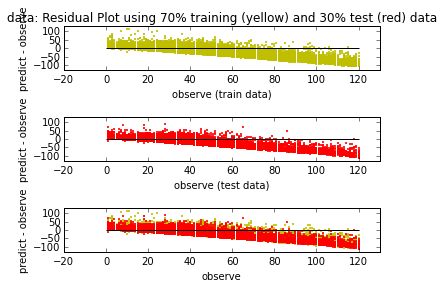

In [43]:

plt.figure(1)

plt.subplot(311)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('predict - observe')
plt.xlabel('observe (train data)')

plt.subplot(312)
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe (test data)')

plt.subplot(313)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1, edgecolor='y')
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1, edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe')

plt.tight_layout()
plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()


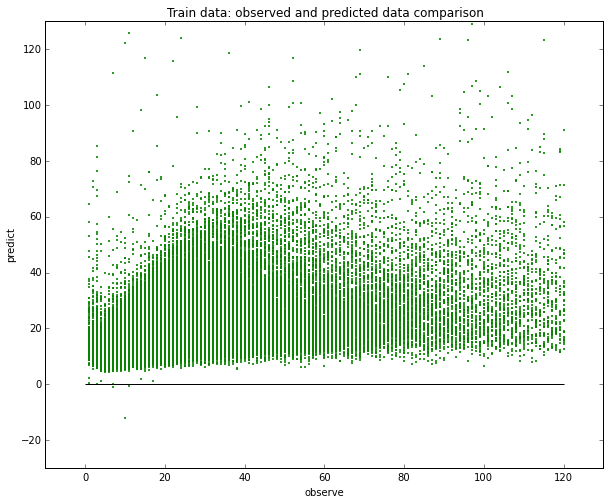

In [44]:

plt.figure(1)

plt.scatter(y_train, lm1.predict(X_train), c='y', s=1,edgecolor='g')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 130, -30, 130])
plt.title('Train data: observed and predicted data comparison')
plt.ylabel('predict')
plt.xlabel('observe')
plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()


In [45]:
'''
x = y_test
y = lm1.predict(X_test)

# Calculate the point density
start = timeit.default_timer()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
stop = timeit.default_timer()
print 'finished calculating z:', stop - start

# Sort the points by density, so that the densest points are plotted last
start = timeit.default_timer()
idx = z.argsort()
stop = timeit.default_timer()
print 'finished sorting data:', stop - start

x, y, z = x[idx], y[idx], z[idx]
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=5, edgecolor='')
plt.axis([0, 130, 0, 130])
plt.title('Test data: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')
plt.show()
'''

"\nx = y_test\ny = lm1.predict(X_test)\n\n# Calculate the point density\nstart = timeit.default_timer()\nxy = np.vstack([x,y])\nz = gaussian_kde(xy)(xy)\nstop = timeit.default_timer()\nprint 'finished calculating z:', stop - start\n\n# Sort the points by density, so that the densest points are plotted last\nstart = timeit.default_timer()\nidx = z.argsort()\nstop = timeit.default_timer()\nprint 'finished sorting data:', stop - start\n\nx, y, z = x[idx], y[idx], z[idx]\nfig, ax = plt.subplots()\nax.scatter(x, y, c=z, s=5, edgecolor='')\nplt.axis([0, 130, 0, 130])\nplt.title('Test data: scatter plot colored by density')\nplt.ylabel('predict')\nplt.xlabel('observe')\nplt.show()\n"

# Model 2 - without vehicle IDs 

In [46]:
X2_train = df_train[['ON','OFF','Floor','three_doors','Express','OWL','Rapid',
                     'on_threedoors','off_threedoors','on_floor','off_floor',
                     'on_express','off_express','on_rapid','off_rapid',
                     'on_owl','off_owl', 'friction']]

X2_test = df_test[['ON','OFF','Floor','three_doors','Express','OWL','Rapid',
                   'on_threedoors','off_threedoors','on_floor','off_floor',
                   'on_express','off_express','on_rapid','off_rapid',
                   'on_owl','off_owl', 'friction']]

y2_train = y_train
y2_test = y_test

In [47]:
lm2 = LinearRegression()
lm2.fit(X2_train, y2_train)
pred2_train = lm2.predict(X2_train)
pred2_test = lm2.predict(X2_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

# Construct a data frame that contains features and estimated coefficients
sklearn_results2 = pd.DataFrame(zip(X2_train.columns, lm2.coef_), columns = ['features', 'estimatedCoefficients'])
# p-values
scores, pvalues = chi2(X2_train, y2_train)
sklearn_results2['pvalues'] = pd.DataFrame(pvalues)
sklearn_results2['scores'] = pd.DataFrame(scores)
stop = timeit.default_timer()
print 'build model without veh ids:', stop - start

build model without veh ids: 657.94199255


In [48]:
print sklearn_results2

          features  estimatedCoefficients  pvalues     scores
0               ON                  2.362    0.000 200577.041
1              OFF                  1.645    0.000  96460.002
2            Floor                 -2.432    0.000   3605.677
3      three_doors                  1.277    0.000   1902.056
4          Express                 -0.942    0.000    423.576
5              OWL                 -0.177    0.000    316.882
6            Rapid                  2.279    0.000   2620.776
7    on_threedoors                 -0.538    0.000  92403.899
8   off_threedoors                 -0.526    0.000  51158.197
9         on_floor                 -0.321    0.000  31431.647
10       off_floor                 -0.317    0.000  13552.465
11      on_express                 -0.287    0.000  13116.573
12     off_express                 -0.260    0.000  14657.034
13        on_rapid                 -0.177    0.000  58868.510
14       off_rapid                 -0.325    0.000  34111.493
15      

In [49]:
#sklearn_results2.to_csv('R:/Angela/fast_trips/muni_apc_2015/passenger_var_datasets_withoutVeh_6day_absOnOff_03082016.csv')

In [50]:
# R-square
R22 = r2_score(y2_train, pred2_train) 
print R22

0.252184360569


# Correlation table

find the top correlations in a correlation matrix with Pandas

In [51]:
c2 = X2_train.corr().abs()
s2 = c2.unstack()
so2 = s2.order(kind="quicksort")

In [52]:
print len(so2)
soo2 = so2.dropna()
soo2 = soo2[soo2 >= 0.500]
soo2 = soo2[soo2 != 1.0]
print len(soo2)

324
24


In [53]:
soo2

Floor           on_floor         0.504
on_floor        Floor            0.504
Floor           off_floor        0.510
off_floor       Floor            0.510
Express         off_express      0.521
off_express     Express          0.521
three_doors     on_threedoors    0.538
on_threedoors   three_doors      0.538
three_doors     off_threedoors   0.557
off_threedoors  three_doors      0.557
Express         on_express       0.569
on_express      Express          0.569
off_threedoors  OFF              0.570
OFF             off_threedoors   0.570
ON              on_threedoors    0.574
on_threedoors   ON               0.574
OWL             off_owl          0.598
off_owl         OWL              0.598
Rapid           on_rapid         0.616
on_rapid        Rapid            0.616
off_rapid       Rapid            0.633
Rapid           off_rapid        0.633
on_owl          OWL              0.640
OWL             on_owl           0.640
dtype: float64

# Plots

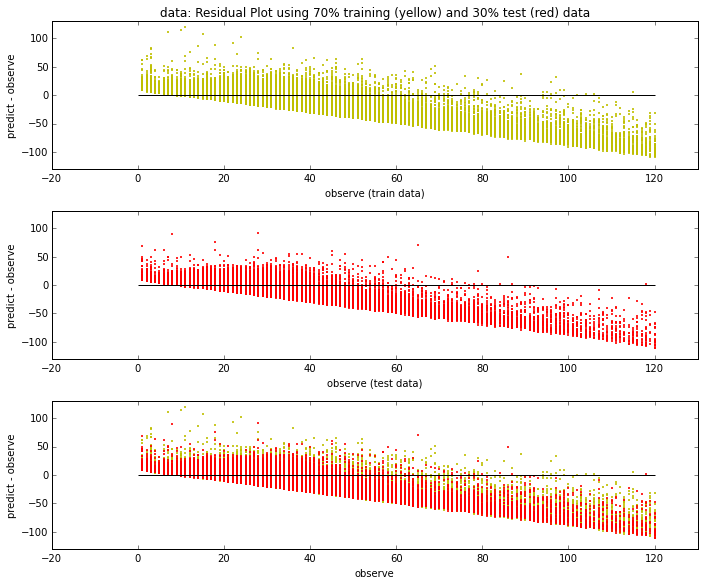

In [54]:
plt.figure(1)
plt.subplot(311)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('predict - observe')
plt.xlabel('observe (train data)')

plt.subplot(312)
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe (test data)')

plt.subplot(313)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1, edgecolor='y')
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1, edgecolor='r')

plt.tight_layout()
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe')

plt.show()

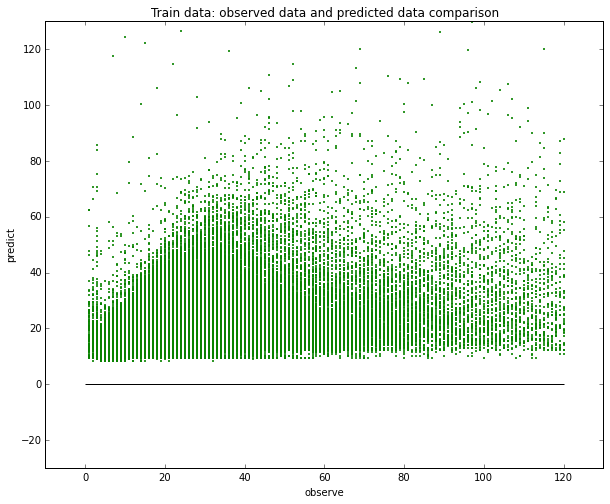

In [55]:
plt.figure(1)

plt.scatter(y2_train, lm2.predict(X2_train), c='y', s=1,edgecolor='g')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 130, -30, 130])
plt.title('Train data: observed data and predicted data comparison')
plt.ylabel('predict')
plt.xlabel('observe')
plt.show()

In [56]:
'''
x2 = y2_test
y2 = lm2.predict(X2_test)

# Calculate the point density
start = timeit.default_timer()
xy2 = np.vstack([x2,y2])
z2 = gaussian_kde(xy2)(xy2)
stop = timeit.default_timer()
print 'z:', stop - start

# Sort the points by density, so that the densest points are plotted last
start = timeit.default_timer()
idx = z2.argsort()
stop = timeit.default_timer()
print 'sort data:', stop - start

x2, y2, z2 = x2[idx], y2[idx], z2[idx]
fig, ax = plt.subplots()
ax.scatter(x2, y2, c=z2, s=5, edgecolor='')

plt.axis([0, 130, 0, 130])
plt.title('Test dataset: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')

plt.show()
'''

"\nx2 = y2_test\ny2 = lm2.predict(X2_test)\n\n# Calculate the point density\nstart = timeit.default_timer()\nxy2 = np.vstack([x2,y2])\nz2 = gaussian_kde(xy2)(xy2)\nstop = timeit.default_timer()\nprint 'z:', stop - start\n\n# Sort the points by density, so that the densest points are plotted last\nstart = timeit.default_timer()\nidx = z2.argsort()\nstop = timeit.default_timer()\nprint 'sort data:', stop - start\n\nx2, y2, z2 = x2[idx], y2[idx], z2[idx]\nfig, ax = plt.subplots()\nax.scatter(x2, y2, c=z2, s=5, edgecolor='')\n\nplt.axis([0, 130, 0, 130])\nplt.title('Test dataset: scatter plot colored by density')\nplt.ylabel('predict')\nplt.xlabel('observe')\n\nplt.show()\n"

# Trend line plot

In [60]:
lm3 = smf.ols(formula = 'COMPUTE_DOORDWELL ~ ON + OFF + Floor+ three_doors  + Express + Rapid + OWL + on_threedoors+ off_threedoors + on_floor + off_floor +  on_express + off_express + on_rapid + off_rapid+ on_owl + off_owl + friction', data = df_train).fit()
print lm3.summary()

                            OLS Regression Results                            
Dep. Variable:      COMPUTE_DOORDWELL   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     3535.
Date:                Fri, 18 Mar 2016   Prob (F-statistic):               0.00
Time:                        11:45:08   Log-Likelihood:            -7.7407e+05
No. Observations:              188729   AIC:                         1.548e+06
Df Residuals:                  188710   BIC:                         1.548e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         10.5553      0.072    146.

In [61]:
df_test['on+off'] = df_test['ON'] + df_test['OFF']
X3_test = df_test[['ON','OFF','on+off', 'Floor','three_doors',
                   'Express','OWL','Rapid','on_threedoors','off_threedoors',
                   'on_floor','off_floor','on_express','off_express',
                   'on_rapid','off_rapid','on_owl','off_owl', 'friction']]

In [62]:
df_est = []
df_est = pd.DataFrame(lm3.predict(X3_test), index = X3_test.index, columns = ['Dwell_Time_Esti'])
test = pd.concat([X3_test, df_est], axis=1, join='inner')
test.head()

,ON,OFF,on+off,Floor,three_doors,Express,OWL,Rapid,on_threedoors,off_threedoors,on_floor,off_floor,on_express,off_express,on_rapid,off_rapid,on_owl,off_owl,friction,Dwell_Time_Esti
19,1,1,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,14.562
37,1,0,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12.918
56,1,0,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12.918
59,3,2,5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,20.932
61,5,0,5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,22.367


In [63]:
test_artic = test[test.three_doors == 1]
test_std = test[test.three_doors == 0]
test_low = test[test.Floor == 1]
test_exp = test[test.Express == 1]
test_rapid = test[test.Rapid == 1]
test_owl = test[test.OWL == 1]
test_local = test[(test.Express != 1) & (test.OWL != 1) & (test.Rapid != 1)]

19996 19996


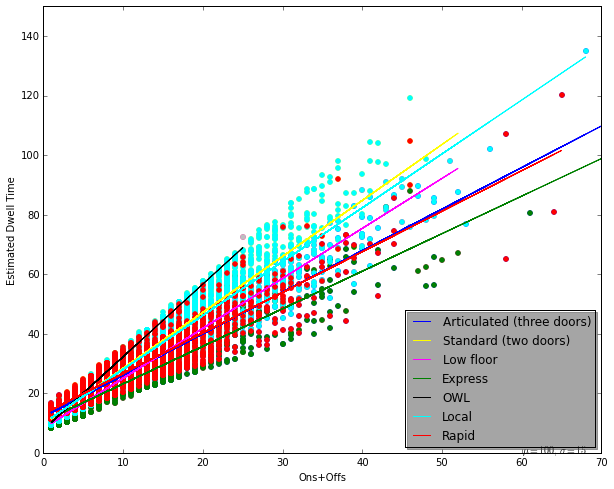

In [65]:
fig, ax = plt.subplots()

# Articulated bus
x1 = test_artic['on+off']
y1 = test_artic['Dwell_Time_Esti']
print len(x1), len(y1)
# plot the data itself
ax.scatter(x1, y1, color = 'blue')
#plot the trend line
fit = np.polyfit(x1, y1, deg=1)
ax.plot(x1, fit[0] * x1 + fit[1], color='blue', label='Articulated (three doors)')

#Standard bus
x2 = test_std['on+off']
y2 = test_std['Dwell_Time_Esti']
ax.scatter(x2, y2, color = 'yellow')
fit = np.polyfit(x2, y2, deg=1)
ax.plot(x2, fit[0] * x2 + fit[1], color='yellow', label='Standard (two doors)')

#Low floor
x7 = test_low['on+off']
y7 = test_low['Dwell_Time_Esti']
ax.scatter(x7, y7, color = 'magenta')
fit = np.polyfit(x7, y7, deg=1)
ax.plot(x7, fit[0] * x7 + fit[1], color='magenta', label= 'Low floor')

#Express
x4 = test_exp['on+off']
y4 = test_exp['Dwell_Time_Esti']
ax.scatter(x4, y4, color = 'green')
fit = np.polyfit(x4, y4, deg=1)
ax.plot(x4, fit[0] * x4 + fit[1], color='green', label= 'Express')

#OWL
x5 = test_owl['on+off']
y5 = test_owl['Dwell_Time_Esti']
ax.scatter(x5, y5, color = '0.75')
fit = np.polyfit(x5, y5, deg=1)
ax.plot(x5, fit[0] * x5 + fit[1], color='black', label= 'OWL')

#Local
x6 = test_local['on+off']
y6 = test_local['Dwell_Time_Esti']
ax.scatter(x6, y6, color = 'cyan')
fit = np.polyfit(x6, y6, deg=1)
ax.plot(x6, fit[0] * x6 + fit[1], color='cyan', label= 'Local')

#Rapid
x8 = test_rapid['on+off']
y8 = test_rapid['Dwell_Time_Esti']
ax.scatter(x8, y8, color = 'red')
fit = np.polyfit(x8, y8, deg=1)
ax.plot(x8, fit[0] * x8 + fit[1], color='red', label= 'Rapid')

plt.xlabel('Ons+Offs')
plt.ylabel('Estimated Dwell Time')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
ax.legend(loc='lower right', shadow=True)
#plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.axis([0, 70, 0, 150])

fig.show()

#three doors trend is exactly as same as rapid ride bus... 

In [57]:
print 'end'

end
